# WSU size of computing estimate numbers (Database)

The goal here is to put together some numbers on the type of projects ALMA would process as part of the WSU to be used to produce a total size of computing estimate.

Amanda Kepley (20220921)

In [1]:
import numpy as np
import astropy.units as u
from ast import literal_eval
from astropy import constants as const
from matplotlib import pyplot as plt, ticker as mticker
import re
import math
from astropy.table import Table, QTable, vstack, join, unique
from importlib import reload
import pickle
import pandas as pd

## Read in massaged cycle 7 and 8 data <a id="readin"></a>

In [2]:
cycle7tab = Table.read('data/result_table_cycle7_with_calc_values_20220923.csv')
cycle8tab = Table.read('data/result_table_cycle8_with_calc_values_20220923.csv')

In [3]:
cycle7tab.columns

<TableColumns names=('obs_publisher_did','facility_name','instrument_name','obs_id','dataproduct_type','calib_level','target_name','s_ra','s_dec','s_fov','s_resolution','t_min','t_max','t_exptime','t_resolution','em_min','em_max','em_res_power','pol_states','o_ucd','access_url','access_format','proposal_id','data_rights','gal_longitude','gal_latitude','band_list','em_resolution','bandwidth','antenna_arrays','is_mosaic','spatial_resolution','frequency_support','frequency','velocity_resolution','publication_year','proposal_abstract','schedblock_name','sensitivity_10kms','cont_sensitivity_bandwidth','pwv','group_ous_uid','member_ous_uid','asdm_uid','type','scan_intent','science_observation','spatial_scale_max','qa2_passed','science_keyword','scientific_category','collections','array','points_per_fov','spw_freq','spw_specwidth','spw_nchan','pb','cell','imsize','spw_nchan_max','mitigated','failed_mitigation_nbin1','failed_mitigation_nbin2','ntarget')>

## Put together WSU mous data base <a id="wsu_db"></a>

In [4]:
import wsu_db

In [5]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [6]:
result = wsu_db.create_database(cycle7tab)

In [7]:
result.columns

<TableColumns names=('mous','proposal_id','array','nant_typical','nant_array','nant_all','band','ntarget','target_name','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_frac_bw_early','wsu_frac_bw_later_2x','wsu_frac_bw_later_4x','wsu_frac_bw_spw','nbase_typical','nbase_array','nbase_all')>

In [8]:
result

mous,proposal_id,array,nant_typical,nant_array,nant_all,band,ntarget,target_name,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all
,,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,
str22,str14,str3,int64,int64,int64,int64,float64,str29,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
uid://A001/X1465/X1002,2019.1.01326.S,7m,10,12,16,3,1.0,Position_8,0.13050363616709187,12.418751976046456,T,220.0,108.514167152526,2.483750395209291,2,4,965.2043680983645,92.45001476575733,2.9778920543263903,14336.0,4096.0,2.0,8.0,92.45001476575733,2,8.0,16.0,32.0,1.6,5,10,20,958.5,71.0,3.108177664666337,297.0,22.0,0.9630973045444989,607.5,45.0,1.9699717592955657,10.08,1669.0,5387.0,2633.0,0.08653324740152588,0.17306649480305175,0.3461329896061035,0.017306649480305178,45.0,66.0,120.0
uid://A001/X1465/X1008,2019.1.01326.S,7m,10,12,16,3,1.0,Position_2,0.13352956949867897,11.495155000772085,T,240.0,99.33587941322293,2.299031000154417,2,4,1116.9672480031732,100.94947251671041,3.1673235453701216,8192.0,2048.0,2.0,8.0,100.94947251671041,2,8.0,16.0,32.0,1.6,5,10,20,1107.0,82.0,3.2874887082848767,324.0,24.0,0.9621918170589883,661.5,49.0,1.9644749598287679,10.08,1445.0,4938.0,2418.0,0.07924756613934501,0.15849513227869003,0.31699026455738005,0.015849513227869004,45.0,66.0,120.0
uid://A001/X1465/X100e,2019.1.01326.S,7m,10,12,16,3,1.0,Position_3,0.1335711696824279,11.477738486513816,T,240.0,99.3358716017038,2.295547697302763,2,4,1116.9768029798806,100.9494845484696,3.1673495625218457,8192.0,2048.0,2.0,8.0,100.9494845484696,2,8.0,16.0,32.0,1.6,5,10,20,1107.0,82.0,3.2874883164624453,324.0,24.0,0.9621917023792522,661.5,49.0,1.9644747256909736,10.08,1445.0,4938.0,2418.0,0.07924755669414937,0.15849511338829875,0.3169902267765975,0.015849511338829874,45.0,66.0,120.0
uid://A001/X1465/X1014,2019.1.01326.S,7m,10,12,16,3,1.0,Position_4,0.1335853198822303,11.302668272847619,T,245.0,99.33587213428518,2.2605336545695236,2,4,1116.9790739480793,100.94948499173799,3.1673558199446665,8192.0,2048.0,2.0,8.0,100.94948499173799,2,8.0,16.0,32.0,1.6,5,10,20,1107.0,82.0,3.28748830202711,324.0,24.0,0.9621916981542762,661.5,49.0,1.9644747170649806,10.08,1445.0,4938.0,2418.0,0.07924755634617398,0.15849511269234795,0.3169902253846959,0.015849511269234794,45.0,66.0,120.0
uid://A001/X1465/X101a,2019.1.01326.S,7m,10,12,16,3,1.0,Position_5,0.1336314854176951,11.413765574280458,T,240.0,99.33587285679403,2.2827531148560913,2,4,1116.978577743549,100.94948404645515,3.1673544786256693,8192.0,2048.0,2.0,8.0,100.94948404645515,2,8.0,16.0,32.0,1.6,5,10,20,1107.0,82.0,3.2874883328108857,324.0,24.0,0.9621917071641618,661.5,49.0,1.9644747354601635,10.08,1445.0,4938.0,2418.0,0.0792475570882417,0.1584951141764834,0.3169902283529668,0.015849511417648343,45.0,66.0,120.0
uid://A001/X1465/X1020,2019.1.01326.S,7m,10,12,16,3,1.0,Position_6,0.13371358744210624,12.310711444421296,T,225.0,99.33586798161843,2.4621422888842592,2,4,1116.9863042364896,100.94949231787314,3.1673755615409136,8192.0,2048.0,2.0,8.0,100.94949231787314,2,

In [9]:
result_c8 = wsu_db.create_database(cycle8tab)

In [10]:
result_c8.columns

<TableColumns names=('mous','proposal_id','array','nant_typical','nant_array','nant_all','band','ntarget','target_name','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_frac_bw_early','wsu_frac_bw_later_2x','wsu_frac_bw_later_4x','wsu_frac_bw_spw','nbase_typical','nbase_array','nbase_all')>

In [11]:
result_c8

mous,proposal_id,array,nant_typical,nant_array,nant_all,band,ntarget,target_name,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all
,,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,
str22,str14,str3,int64,int64,int64,int64,float64,str33,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
uid://A001/X158f/X111,2021.1.01571.S,12m,47,54,66,8,1.0,G09v1.40,0.004000240613311581,0.45833271459124353,F,240.0,14.397483872538897,0.0916665429182487,2,4,31176.314691250842,404.3315523311515,22.83384100374022,512.0,128.0,2.0,8.0,404.3315523311515,2,8.0,16.0,32.0,1.6,5,10,20,31171.5,2309.0,23.112172549159283,13486.5,999.0,9.999593060463459,13486.5,999.0,9.999593060463459,3.024,51.0,118.0,118.0,0.019785742551815304,0.03957148510363061,0.07914297020726122,0.003957148510363061,1081.0,1431.0,2145.0
uid://A001/X158f/X115,2021.1.01571.S,12m,47,54,66,7,1.0,SPT0125-47,0.0045375135989717905,0.2911647419354411,F,430.0,16.331349317037823,0.05823294838708822,2,4,31160.819141109412,356.47101883940036,25.85577672790684,512.0,128.0,2.0,8.0,356.47101883940036,2,8.0,16.0,32.0,1.6,5,10,20,31158.0,2308.0,26.203906945300194,11880.0,880.0,9.991091036336297,11880.0,880.0,9.991091036336297,3.024,51.0,134.0,134.0,0.022442217115002588,0.044884434230005175,0.08976886846001035,0.004488443423000517,1081.0,1431.0,2145.0
uid://A001/X158f/X13a,2021.1.01543.S,12m,47,54,66,3,1.0,ACT-S_J0007.5+1606,0.016370669248356715,3.2510106691183673,F,140.0,59.27082942119824,0.6502021338236735,2,20,7727.466820763161,98.80399468281071,20.998292318707925,4800.0,240.0,1.875,37.5,98.80399468281071,2,8.0,16.0,32.0,1.6,5,10,20,7722.0,572.0,23.430200045127812,3294.0,244.0,9.994700718551027,3294.0,244.0,9.994700718551027,3.024,207.0,485.0,485.0,0.08096838620424512,0.16193677240849025,0.3238735448169805,0.01619367724084903,1081.0,1431.0,2145.0
uid://A001/X158f/X13e,2021.1.01543.S,12m,47,54,66,3,1.0,ACT-S_J0732.1+1709,0.016369060528796033,3.1183686839850737,F,150.0,59.265060245387154,0.6236737367970147,2,20,966.0466580540649,98.81361279933466,2.6250367912778914,76800.0,3840.0,1.875,37.5,98.81361279933466,2,8.0,16.0,32.0,1.6,5,10,20,958.5,71.0,2.9080109799905505,324.0,24.0,0.9829896270390595,648.0,48.0,1.965979254078119,3.024,1669.0,4938.0,2469.0,0.08096050506974142,0.16192101013948285,0.3238420202789657,0.016192101013948284,1081.0,1431.0,2145.0
uid://A001/X158f/X142,2021.1.01543.S,12m,47,54,66,3,1.0,ACT-S_J0503.2-3609,0.016369146727628202,2.782605450987199,F,160.0,59.26537233287519,0.5565210901974396,2,20,966.0415709169566,98.81309245345668,2.6250367912778914,76800.0,3840.0,1.875,37.5,98.81309245345668,2,8.0,16.0,32.0,1.6,5,10,20,958.5,71.0,2.908026293462571,324.0,24.0,0.9829948034239677,648.0,48.0,1.9659896068479354,3.024,1669.0,4938.0,2469.0,0.08096093140459287,0.16192186280918575,0.3238437256183715,0.016192186280918577,1081.0,1431.0,2145.0
uid://A001/X158f/X146,2021.1.01543.S,12m,47,54,66,3,1.0,ACT-S_J2114.9+0557,0.016372897494422896,2.67464628092988,F,170.0,59.27895218491757,0.534929256185976,2,20,965.820266370970

In [12]:
# save data bases if what's desired
result.write('data/cycle7wsu_20230103.ecsv',overwrite=True)
result_c8.write('data/cycle8wsu_20230103.ecsv',overwrite=True)

In [13]:
len(result)

11519

In [14]:
len(result_c8)

10843

## Adding in L80 and BLC tint info

I don't have BLC tint information easily accessible, so making some educated guesses based on array and L80. These files are based on downloads of data from interactive interface where each row is project/mous/src. The astroquery interface returns project/mous/src/spw.

In [15]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [16]:
result_L80 = wsu_db.add_l80(result,l80_file='data/cycle7_L80.csv')

In [42]:
result_c8_L80 = wsu_db.add_l80(result_c8,l80_file='data/cycle8_L80.csv')

In [18]:
wsu_db.add_blc_tint(result_L80,breakpt_12m=3000.0 * u.m)

In [43]:
wsu_db.add_blc_tint(result_c8_L80,breakpt_12m=3000.0 * u.m)

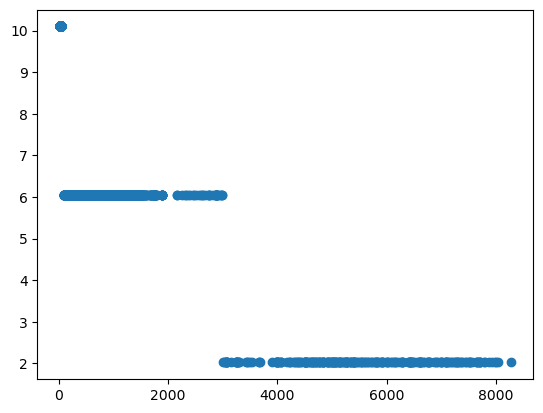

In [19]:
plt.scatter(result_L80['L80'],result_L80['blc_tint'])

In [20]:
len(result_L80)

11519

In [21]:
len(result_c8_L80)

10843

## Adding in calibration TOS information

This is needed to get the total number of visibilities and the data volume. Also necessary to start refine the data rates.

In [22]:
import large_cubes
from importlib import reload

In [23]:
reload(large_cubes)
tos_db = large_cubes.calc_time_on_source('data/project_mous_band_array_eb_size___source_intent_inttime')

Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: DIFFGAIN PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS DIFFGAIN FLUX PHASE WVR
Intent not recognized: BANDPASS PHASE WVR
Intent not recognized: BANDPASS PHASE WVR
project_id list greater than 1. This shouldn't happen. MOUS: uid://A002/X445835/X6
made it to table creation


In [24]:
tos_db.columns

<TableColumns names=('proposal_id','mous','band','array','bp_time','flux_time','phase_time','pol_time','check_time','target_time','target_name','target_time_tot','ntarget','time_tot','cal_time')>

In [25]:
len(tos_db)

22430

In [26]:
tos_db

proposal_id,mous,band,array,bp_time,flux_time,phase_time,pol_time,check_time,target_time,target_name,target_time_tot,ntarget,time_tot,cal_time
,,,,s,s,s,s,s,s,,s,,s,s
str14,str22,float64,str6,float64,float64,float64,float64,float64,float64,str35,float64,float64,float64,float64
2019.1.01326.S,uid://A001/X1465/X1002,3.0,7m,1209.6,0.0,362.88,0.0,0.0,60.48,Position_8,60.48,1.0,1632.96,1572.48
2019.1.01326.S,uid://A001/X1465/X1008,3.0,7m,604.8,0.0,120.96,0.0,0.0,10.08,Position_2,10.08,1.0,735.84,725.76
2019.1.01326.S,uid://A001/X1465/X100e,3.0,7m,604.8,0.0,120.96,0.0,0.0,10.08,Position_3,10.08,1.0,735.84,725.76
2019.1.01326.S,uid://A001/X1465/X1014,3.0,7m,604.8,0.0,120.96,0.0,0.0,10.08,Position_4,10.08,1.0,735.84,725.76
2019.1.01326.S,uid://A001/X1465/X101a,3.0,7m,604.8,0.0,120.96,0.0,0.0,10.08,Position_5,10.08,1.0,735.84,725.76
2019.1.01326.S,uid://A001/X1465/X1020,3.0,7m,604.8,0.0,120.96,0.0,0.0,10.08,Position_6,10.08,1.0,735.84,725.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022.A.00009.T,uid://A001/X3571/X16,5.0,7m,1209.6,0.0,604.8,0.0,0.0,3084.48,GRB221009A,3084.48,1.0,4898.88,1814.3999999999999


In [27]:
tos_db.write('data/tos_db_20230103.ecsv',overwrite=True)

In [28]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [44]:
result_tos = wsu_db.add_tos_to_db(result_L80,tos_db)

In [45]:
result_c8_tos = wsu_db.add_tos_to_db(result_c8_L80,tos_db)

In [46]:
result_tos.write('data/result_tos_20230103.ecsv',overwrite=True)
result_c8_tos.write('data/result_c8_tos_20230103.ecsv',overwrite=True)

In [32]:
result_tos

mous,proposal_id,array,nant_typical,nant_array,nant_all,band,ntarget,target_name,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,Project code,Array,L80,blc_tint,bp_time,flux_time,phase_time,pol_time,check_time,target_time,target_time_tot,time_tot,cal_time
,,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,m,s,s,s,s,s,s,s,s,s,s
str22,str14,str6,int64,int64,int64,float64,float64,str35,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
uid://A001/X1465/X1002,2019.1.01326.S,7m,10,12,16,3.0,1.0,Position_8,0.13050363616709187,12.418751976046456,T,220.0,108.514167152526,2.483750395209291,2,4,965.2043680983645,92.45001476575733,2.9778920543263903,14336.0,4096.0,2.0,8.0,92.45001476575733,2,8.0,16.0,32.0,1.6,5,10,20,958.5,71.0,3.108177664666337,297.0,22.0,0.9630973045444989,607.5,45.0,1.9699717592955657,10.08,1669.0,5387.0,2633.0,0.08653324740152588,0.17306649480305175,0.3461329896061035,0.017306649480305178,45.0,66.0,120.0,2019.1.01326.S,7m,30.03768,10.1,1209.6,0.0,362.88,0.0,0.0,60.48,60.48,1632.96,1572.48
uid://A001/X1465/X1008,2019.1.01326.S,7m,10,12,16,3.0,1.0,Position_2,0.13352956949867897,11.495155000772085,T,240.0,99.33587941322293,2.299031000154417,2,4,1116.9672480031732,100.94947251671041,3.1673235453701216,8192.0,2048.0,2.0,8.0,100.94947251671041,2,8.0,16.0,32.0,1.6,5,10,20,1107.0,82.0,3.2874887082848767,324.0,24.0,0.9621918170589883,661.5,49.0,1.9644749598287679,10.08,1445.0,4938.0,2418.0,0.07924756613934501,0.15849513227869003,0.31699026455738005,0.015849513227869004,45.0,66.0,120.0,2019.1.01326.S,7m,30.609047,10.1,604.8,0.0,120.96,0.0,0.0,10.08,10.08,735.84,725.76
uid://A001/X1465/X100e,2019.1.01326.S,7m,10,12,16,3.0,1.0,Position_3,0.1335711696824279,11.477738486513816,T,240.0,99.3358716017038,2.295547697302763,2,4,1116.9768029798806,100.9494845484696,3.1673495625218457,8192.0,2048.0,2.0,8.0,100.9494845484696,2,8.0,16.0,32.0,1.6,5,10,20,1107.0,82.0,3.2874883164624453,324.0,24.0,0.9621917023792522,661.5,49.0,1.9644747256909736,10.08,1445.0,4938.0,2418.0,0.07924755669414937,0.15849511338829875,0.3169902267765975,0.015849511338829874,45.0,66.0,120.0,2019.1.01326.S,7m,30.655828,10.1,604.8,0.0,120.96,0.0,0.0,10.08,10.08,735.84,725.76
uid://A001/X1465/X1014,2019.1.01326.S,7m,10,12,16,3.0,1.0,Position_4,0.1335853198822303,11.302668272847619,T,245.0,99.33587213428518,2.2605336545695236,2,4,1116.9790739480793,100.94948499173799,3.1673558199446665,8192.0,2048.0,2.0,8.0,100.94948499173799,2,8.0,16.0,32.0,1.6,5,10,20,1107.0,82.0,3.28748830202711,324.0,24.0,0.9621916981542762,661.5,49.0,1.9644747170649806,10.08,1445.0,4938.0,2418.0,0.07924755634617398,0.15849511269234795,0.3169902253846959,0.015849511269234794,45.0,66.0,120.0,2019.1.01326.S,7m,31.127703,10.1,604.8,0.0,120.96,0.0,0.0,10.08,10.08,735.84,725.76
uid://A001/X1465/X101a,2019.1.01326.S,7m,10,12,16,3.0,1.0,Position_5,0.1336314854176951,11.413765574280458,T,240.0,99.33587285679403,2.2827531148560

In [33]:
result_tos.columns

<TableColumns names=('mous','proposal_id','array','nant_typical','nant_array','nant_all','band','ntarget','target_name','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_frac_bw_early','wsu_frac_bw_later_2x','wsu_frac_bw_later_4x','wsu_frac_bw_spw','nbase_typical','nbase_array','nbase_all','Project code','Array','L80','blc_tint','bp_time','flux_time','phase_time','pol_time','check_time','target_time'

In [34]:
len(result_c8_tos)

10843

In [35]:
len(result_c8_tos)

10843

## Adding in data rates

In [36]:
reload(large_cubes)
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [37]:
len(result_tos)

11519

In [47]:
wsu_db.add_rates_to_db(result_tos)

In [40]:
result_tos

mous,proposal_id,array,nant_typical,nant_array,nant_all,band,ntarget,target_name,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,Project code,Array,L80,blc_tint,bp_time,flux_time,phase_time,pol_time,check_time,target_time,target_time_tot,time_tot,cal_time,mfssize,wsu_cubesize_stepped2,wsu_productsize_early_stepped2,wsu_datarate_early_stepped2_typical,wsu_visrate_early_stepped2_typical,wsu_datavol_early_stepped2_typical_target,wsu_datavol_early_stepped2_typical_target_tot,wsu_datavol_early_stepped2_typical_cal,wsu_datavol_early_stepped2_typical_total,wsu_nvis_early_stepped2_typical_target,wsu_nvis_early_stepped2_typical_target_tot,wsu_nvis_early_stepped2_typical_cal,wsu_nvis_early_stepped2_typical_total,wsu_productsize_later_2x_stepped2,wsu_datarate_later_2x_stepped2_typical,wsu_visrate_later_2x_stepped2_typical,wsu_datavol_later_2x_stepped2_typical_target,wsu_datavol_later_2x_stepped2_typical_target_tot,wsu_datavol_later_2x_stepped2_typical_cal,wsu_datavol_later_2x_stepped2_typical_total,wsu_nvis_later_2x_stepped2_typical_target,wsu_nvis_later_2x_stepped2_typical_target_tot,wsu_nvis_later_2x_stepped2_typical_cal,wsu_nvis_later_2x_stepped2_typical_total,wsu_productsize_later_4x_stepped2,wsu_datarate_later_4x_stepped2_typical,wsu_visrate_later_4x_stepped2_typical,wsu_datavol_later_4x_stepped2_typical_target,wsu_datavol_later_4x_stepped2_typical_target_tot,wsu_datavol_later_4x_stepped2_typical_cal,wsu_datavol_later_4x_stepped2_typical_total,wsu_nvis_later_4x_stepped2_typical_target,wsu_nvis_later_4x_stepped2_typical_target_tot,wsu_nvis_later_4x_stepped2_typical_cal,wsu_nvis_later_4x_stepped2_typical_total,blc_datarate_typical,blc_visrate_typical,blc_datavol_typical_target,blc_datavol_typical_target_tot,blc_datavol_typical_cal,blc_datavol_typical_total,blc_nvis_typical_target,blc_nvis_typical_target_tot,blc_nvis_typical_cal,blc_nvis_typical_total
,,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,m,s,s,s,s,s,s,s,s,s,s,Gbyte,Gbyte,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gvis,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gvis
str22,str14,str6,int64,int64,int64,float64,float64,str35,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
uid://A001/X1465/X1002,2019.1.01326.S,7m,10,12,16,3.0,1.0,Position_8,0.13050363616709187,12.418751976046456,T,220.0,108.514167152526,2.483750395209291,2,4,965.2043680983645,92.45001476575733,2.977892

In [48]:
wsu_db.add_rates_to_db(result_c8_tos)

# creating per mous version of data base

This is going to be more useful for the DMGs as well as for combining with mitigation information (which is per MOUS). But I don't think the fractions of time are going to be useful, so I'll leave them off and recalculate.

I think that the path forward uses the group_by function and aggregation to get values.

In [49]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [50]:
result_tos_mous = wsu_db.create_per_mous_db(result_tos)

Taking first value. Key aggregation not specified: mous
Taking first value. Key aggregation not specified: proposal_id
Taking first value. Key aggregation not specified: array
Taking first value. Key aggregation not specified: nant_typical
Taking first value. Key aggregation not specified: nant_array
Taking first value. Key aggregation not specified: nant_all
Taking first value. Key aggregation not specified: band
Taking first value. Key aggregation not specified: ntarget
Taking first value. Key aggregation not specified: target_name
Taking first value. Key aggregation not specified: mosaic
Taking first value. Key aggregation not specified: blc_npol
Taking first value. Key aggregation not specified: blc_nspw
Taking first value. Key aggregation not specified: blc_nchan_agg
Taking first value. Key aggregation not specified: blc_nchan_max
Taking first value. Key aggregation not specified: blc_bandwidth_max
Taking first value. Key aggregation not specified: blc_bandwidth_agg
Taking first v

In [51]:
result_tos_mous

mous,proposal_id,array,nant_typical,nant_array,nant_all,band,ntarget,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,Project code,Array,L80,blc_tint,bp_time,flux_time,phase_time,pol_time,check_time,target_time_tot,time_tot,cal_time,mfssize,wsu_cubesize_stepped2,wsu_productsize_early_stepped2,wsu_datarate_early_stepped2_typical,wsu_visrate_early_stepped2_typical,wsu_datavol_early_stepped2_typical_target_tot,wsu_datavol_early_stepped2_typical_cal,wsu_datavol_early_stepped2_typical_total,wsu_nvis_early_stepped2_typical_target_tot,wsu_nvis_early_stepped2_typical_cal,wsu_nvis_early_stepped2_typical_total,wsu_productsize_later_2x_stepped2,wsu_datarate_later_2x_stepped2_typical,wsu_visrate_later_2x_stepped2_typical,wsu_datavol_later_2x_stepped2_typical_target_tot,wsu_datavol_later_2x_stepped2_typical_cal,wsu_datavol_later_2x_stepped2_typical_total,wsu_nvis_later_2x_stepped2_typical_target_tot,wsu_nvis_later_2x_stepped2_typical_cal,wsu_nvis_later_2x_stepped2_typical_total,wsu_productsize_later_4x_stepped2,wsu_datarate_later_4x_stepped2_typical,wsu_visrate_later_4x_stepped2_typical,wsu_datavol_later_4x_stepped2_typical_target_tot,wsu_datavol_later_4x_stepped2_typical_cal,wsu_datavol_later_4x_stepped2_typical_total,wsu_nvis_later_4x_stepped2_typical_target_tot,wsu_nvis_later_4x_stepped2_typical_cal,wsu_nvis_later_4x_stepped2_typical_total,blc_datarate_typical,blc_visrate_typical,blc_datavol_typical_target_tot,blc_datavol_typical_cal,blc_datavol_typical_total,blc_nvis_typical_target_tot,blc_nvis_typical_cal,blc_nvis_typical_total
,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,m,s,s,s,s,s,s,s,s,s,Gbyte,Gbyte,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis
str22,str14,str3,int64,int64,int64,float64,float64,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
uid://A001/X1465/X1002,2019.1.01326.S,7m,10,12,16,3.0,1.0,0.13050363616709187,12.418751976046456,T,220.0,108.514167152526,2.483750395209291,2,4,965.2043680983645,92.45001476575733,2.9778920543263903,14336.0,4096.0,2.0,8.0,92.45001476575733,2,8.0,16.0,32.0,1.6,5,10,20,958.5,71.0,3.108177664666337,297.0,22.0,0.9630973045444989,607.5,45.0,1.9699717592955657,10.08,1669.0,5387.0,2633.0,0.08653324740152588,0.17306649480305175,0.3461329896061035,0.017306649480305178,45.0,66.0,120.0,2019.1.01326.S,7m,30.03768,10.1,1209.6,0.0,362.88,0.0,0.0,60.48,1632.96,1572.48,0.0001936,0.5097488,5.099424,0.0005746626984126984,0.8463214285714287,0.0347556,0.9036456,0.93

In [52]:
len(result_tos_mous)

2719

In [53]:
result_tos_mous.columns

<TableColumns names=('mous','proposal_id','array','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_frac_bw_early','wsu_frac_bw_later_2x','wsu_frac_bw_later_4x','wsu_frac_bw_spw','nbase_typical','nbase_array','nbase_all','Project code','Array','L80','blc_tint','bp_time','flux_time','phase_time','pol_time','check_time','target_time_tot','time_tot

In [54]:
result_c8_tos_mous = wsu_db.create_per_mous_db(result_c8_tos)

Taking first value. Key aggregation not specified: mous
Taking first value. Key aggregation not specified: proposal_id
Taking first value. Key aggregation not specified: array
Taking first value. Key aggregation not specified: nant_typical
Taking first value. Key aggregation not specified: nant_array
Taking first value. Key aggregation not specified: nant_all
Taking first value. Key aggregation not specified: band
Taking first value. Key aggregation not specified: ntarget
Taking first value. Key aggregation not specified: target_name
Taking first value. Key aggregation not specified: mosaic
Taking first value. Key aggregation not specified: blc_npol
Taking first value. Key aggregation not specified: blc_nspw
Taking first value. Key aggregation not specified: blc_nchan_agg
Taking first value. Key aggregation not specified: blc_nchan_max
Taking first value. Key aggregation not specified: blc_bandwidth_max
Taking first value. Key aggregation not specified: blc_bandwidth_agg
Taking first v

In [55]:
len(result_c8_tos_mous)

2481

## Adding in current mitigation information

In [56]:
c7_pickle = '/Users/akepley/Dropbox/Support/naasc/WSU/mitigation/weblog_stats/allc7_stats.20220930.pkl'
c7_mit = pickle.load(open(c7_pickle,'rb'))
c7_rpd = pd.DataFrame(c7_mit).transpose()

In [57]:
c7_astropy = Table.from_pandas(c7_rpd,index=True)
c7_astropy.rename_column('index','mous')

In [58]:
c7_astropy

mous,project,plversion,procedure,nant,totaltime,imgtime,cubetime,aggtime,fctime,nEB,npt,nscan,reptgt,nscience,nspw,webpredrms,webcontrms,webcontBW,webfreq,webbm,webdirtyDR,webDRcorr,webcontpk,webfreqline,webbmline,webpredrmsline,webdirtyDRline,webDRcorrline,weblinerms,weblinepk,weblineBW,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,prodsizeaftercube,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw
str22,str14,str4,str20,object,object,object,object,object,object,object,object,object,str35,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str64,str7,str7,str846,str54
uid___A001_X1465_X1002,2019.1.01326.S,C7,hifa_calimage,10,5.1194444444444445,4.113333333333333,3.731666666666667,0.06194444444444445,0.16666666666666666,1,34,2,Position_8,1,4,0.0019,0.0025,2.76,92.6159,13.628499550574158,54.0,2.5,0.105,85.9,15.461953304805961,0.079,38.0,2.5,0.074,3.49,1.8727352000000002,40.0,60.0,1.68,1.68,350.0,11.7,11.7,11.7,False,default,default,default,default,default
uid___A001_X1465_X1008,2019.1.01326.S,C7,hifa_calimage,10,1.9755555555555557,1.267777777777778,0.9855555555555555,0.05583333333333334,0.10694444444444444,1,39,1,Position_2,1,4,0.0014,0.0017,6.65,100.8709,12.991420245685227,6.9,1.5,0.0171,93.9,14.877499789951266,0.085,25.0,2.5,0.077,2.14,1.863162,40.0,60.0,0.86,0.86,350.0,6.88,6.88,6.88,False,default,default,default,default,default
uid___A001_X1465_X100e,2019.1.01326.S,C7,hifa_calimage,10,2.3316666666666666,1.5105555555555559,1.1925000000000001,0.06055555555555556,0.12555555555555556,1,39,1,Position_3,1,4,0.0013,0.0016,6.51,100.8724,13.053160536820192,12.0,2.0,0.0174,93.9,14.458215657542254,0.076,34.0,2.5,0.073,3.27,1.8709740000000001,40.0,60.0,0.839,0.839,350.0,6.71,6.71,6.71,False,default,default,default,default,default
uid___A001_X1465_X1014,2019.1.01326.S,C7,hifa_calimage,9,2.283888888888889,1.5136111111111115,1.2166666666666668,0.04527777777777778,0.1175,1,39,1,Position_4,1,4,0.0014,0.0016,6.85,100.8729,12.373560522339558,4.1,1.5,0.0161,93.9,14.043076585990693,0.095,18.0,2.0,0.09,2.08,1.8709740000000001,40.0,60.0,0.86,0.86,350.0,6.88,6.88,6.88,False,default,default,default,default,default
uid___A001_X1465_X101a,2019.1.01326.S,C7,hifa_calimage,9,2.1558333333333333,1.357777777777778,1.0480555555555557,0.058333333333333334,0.12361111111111112,1,39,1,Position_5,1,4,0.0015,0.0018,6.64,100.8733,12.637444361895326,9.0,1.5,0.0192,93.9,14.30971697833329,0.095,14.0,2.0,0.091,1.54,1.8709740000000001,40.0,60.0,0.86,0.86,350.0,6.88,6.88,6.88,False,default,default,default,default,default
uid___A001_X1465_X1020,2019.1.01326.S,C7,hifa_calimage,9,2.058611111111111,1.3386111111111112,1.0475,0.05,0.10333333333333333,1,39,1,Position_6,1,4,0.0022,0.0043,2.84,100.8397,14.280756282494286,110.0,3.6,0.255,93.9,16.75857989210303,0.1,54.0,2.5,0.084,6.62,1.8709740000000001,40.0,60.0,0.708,0.708,350.0,5.67,5.67,5.67,False,default,default,default,default,default
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uid___A001_X15a2_Xab7,2019.1.01324.T,2021,hifa_calimage_renorm,42,31.281388888888888,13.486944444444443,10.138055555555555,0.21333333333333335,2.5413888888888887,1,1,6,GX_339-4,1,4,3e-05,3.4e-05,6.42,97.5028,0.16244999230532453,64.0,2.0,0.00191,104.5,0.16023732399163437,0.002,6.7,1.0,2.1,0.0161,1.8731187999999999,40.0,60.0,156.0,35.8,500.0,1240.0,71.7,71.7,True,default,0.68pb,default,default,23
uid___A001_X15a2_Xed4,2019.1.00863.T,2021,hifa_calimage_renorm,44,4.855277777777777,0.8577777777777779,0.42083333333333334,0.09805555555555555,0.14888888888888888,1,1,4,GRB211106A,1,4,1.1e-05,1.3e-05,6.94,97.5006,0.41629797020883974,8.2,1.0,0.000155,102.5,0.4131101548013556,0.00014000000000000001,6.1,1.0,0.16,

In [59]:
reload(large_cubes)

<module 'large_cubes' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/large_cubes.py'>

In [60]:
large_cubes.fix_mous_col(c7_astropy)  

In [75]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [76]:
result_tos_mous_mit = wsu_db.join_wsu_and_mit_dbs(result_tos_mous, c7_astropy)

In [77]:
result_tos_mous_mit

mous,proposal_id,array,nant_typical,nant_array,nant_all,band,ntarget,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,Project code,Array,L80,blc_tint,bp_time,flux_time,phase_time,pol_time,check_time,target_time_tot,time_tot,cal_time,mfssize,wsu_cubesize_stepped2,wsu_productsize_early_stepped2,wsu_datarate_early_stepped2_typical,wsu_visrate_early_stepped2_typical,wsu_datavol_early_stepped2_typical_target_tot,wsu_datavol_early_stepped2_typical_cal,wsu_datavol_early_stepped2_typical_total,wsu_nvis_early_stepped2_typical_target_tot,wsu_nvis_early_stepped2_typical_cal,wsu_nvis_early_stepped2_typical_total,wsu_productsize_later_2x_stepped2,wsu_datarate_later_2x_stepped2_typical,wsu_visrate_later_2x_stepped2_typical,wsu_datavol_later_2x_stepped2_typical_target_tot,wsu_datavol_later_2x_stepped2_typical_cal,wsu_datavol_later_2x_stepped2_typical_total,wsu_nvis_later_2x_stepped2_typical_target_tot,wsu_nvis_later_2x_stepped2_typical_cal,wsu_nvis_later_2x_stepped2_typical_total,wsu_productsize_later_4x_stepped2,wsu_datarate_later_4x_stepped2_typical,wsu_visrate_later_4x_stepped2_typical,wsu_datavol_later_4x_stepped2_typical_target_tot,wsu_datavol_later_4x_stepped2_typical_cal,wsu_datavol_later_4x_stepped2_typical_total,wsu_nvis_later_4x_stepped2_typical_target_tot,wsu_nvis_later_4x_stepped2_typical_cal,wsu_nvis_later_4x_stepped2_typical_total,blc_datarate_typical,blc_visrate_typical,blc_datavol_typical_target_tot,blc_datavol_typical_cal,blc_datavol_typical_total,blc_nvis_typical_target_tot,blc_nvis_typical_cal,blc_nvis_typical_total,plversion,procedure,nant,pl_totaltime,pl_imgtime,pl_cubetime,pl_aggtime,pl_fctime,nEB,npt,nscan,reptgt,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw,pl_caltime
,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,m,s,s,s,s,s,s,s,s,s,Gbyte,Gbyte,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,,,,h,h,h,h,h,,,,,Gbyte,Gbyte,Gbyte,Gbyte,Gbyte,Gbyte,Gbyte,,,,,,,h
str22,str14,str3,int64,int64,int64,float64,float64,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,str20,object,object,object,object,object,object,object,object,object,str35,object,object,object,object,object,object,object,object,str64,str7,str7,str846,str54,float64
uid://A001/X1465/X1002,2019.1.01326.S,7m,10,12,16,3.0,1.0,0.13050363616709187,12.418751976046456,T,220.0,108.514167152526,

In [64]:
c8_pickle = '/Users/akepley/Dropbox/Support/naasc/WSU/mitigation/weblog_stats/cycle8_stats.ignacio.20230103.pkl'
c8_mit = pickle.load(open(c8_pickle,'rb'))
c8_rpd = pd.DataFrame(c8_mit).transpose()

In [65]:
c8_astropy = Table.from_pandas(c8_rpd,index=True)
c8_astropy.rename_column('index','mous')

In [66]:
c8_astropy

mous,project,plversion,procedure,nant,totaltime,imgtime,cubetime,aggtime,fctime,nEB,npt,nscan,reptgt,nscience,nspw,webpredrms,webcontrms,webcontBW,webfreq,webbm,webdirtyDR,webcontpk,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,prodsizeaftercube,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw
str22,str14,str4,str20,object,object,object,object,object,object,object,object,object,str29,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str64,str7,str7,str769,str44
uid___A001_X1590_X2130,2021.1.00548.S,2021,hifa_calimage_renorm,9,1.7116666666666667,0.97305555873447,0.7186111111111111,0.05416666666666667,0.05500000317891439,1,4,1,SgrC,1,4,0.00079,0.0032,2.18,97.8589,13.146862743635836,100.0,0.112,40.0,60.0,0.236,0.236,500.0,1.89,1.89,1.89,False,default,default,default,default,default
uid___A001_X1590_X1554,2021.1.00966.S,2021,hifa_calimage_renorm,9,1.2266666666666668,0.5997221554650202,0.06388888888888888,0.09722222222222221,0.02888882213168674,1,1,1,PGC95569,4,4,0.00073,0.0009699999999999999,6.94,233.004,5.6147128154519175,6.6,0.0072699999999999996,40.0,60.0,0.00328,0.00328,500.0,0.106,0.106,0.106,False,default,default,default,default,default
uid___A001_X159b_X12,2021.1.00927.S,2021,hifa_calimage_renorm,9,0.8644444444444445,0.27972223440806077,0.10277777777777779,0.03027777777777778,0.01222223440806071,1,1,2,Betelgeuse,1,4,0.00033,0.0034,5.32,221.0088,6.376143034782078,790.0,0.263,40.0,60.0,0.0212,0.0212,500.0,0.17,0.17,0.17,False,default,default,default,default,default
uid___A001_X1590_X16d5,2021.1.00927.S,2021,hifa_calimage_renorm,9,0.6844444444444444,0.20638888518015547,0.03666666666666667,0.029722222222222223,0.008888885180155437,1,1,1,Betelgeuse,1,4,0.0008900000000000001,0.009,6.44,340.793,4.2673879598649105,590.0,0.514,40.0,60.0,0.0021,0.0021,500.0,0.0169,0.0169,0.0169,False,default,default,default,default,default
uid___A001_X1590_X2199,2021.1.00520.S,2021,hifa_calimage_renorm,47,40.8975,16.9791666536861,12.890833333333333,0.4688888888888889,1.893888875908322,1,1,24,HOPS-153,1,5,4.1e-05,5.8e-05,3.36,336.9324,0.028861739379323625,150.0,0.00431,40.0,60.0,290.0,24.9,500.0,2320.0,199.0,199.0,True,default,0.7pb,3ppb,default,default
uid___A001_X1590_X23be,2021.1.00442.S,2021,hifa_calimage_renorm,44,58.26583333333333,18.17249999470181,10.971111111111112,1.5780555555555555,3.303888883590698,1,1,54,AFGL2591,1,4,2.1e-05,3.3e-05,1.42,104.9525,0.10426936271024197,170.0,0.00365,40.0,60.0,504.0,40.8,500.0,4030.0,81.6,81.6,True,default,0.7pb,3ppb,default,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uid___A001_X1590_X17a6,2021.1.00871.S,2021,hifa_calimage_renorm,42,4.476111111111111,0.7563888801468743,0.28388888888888886,0.08055555555555555,0.06749999125798543,1,1,4,LDS_5606_A,1,4,3.3e-05,4.1e-05,6.45,340.6964,0.5003198976654837,150.0,0.00491,40.0,60.0,0.786,0.786,500.0,1.89,1.89,1.89,False,default,default,default,default,default
uid___A001_X1590_X26fd,2021.1.00389.S,2021,hifa_calimage_renorm,47,9.10361111111111,0.5375000084771051,0.11166666666666668,0.07361111111111111,0.07055556403266058,2,1,5,COSMOS-z10-2,1,4,2.8e-05,3.3e-05,5.66,319.704,0.4187982807987636,8.0,0.000336,40.0,60.0,0.142,0.142,500.0,1.14,1.14,1.14,False,default,default,default,default,default


In [67]:
large_cubes.fix_mous_col(c8_astropy)  

In [68]:
c8_astropy

mous,project,plversion,procedure,nant,totaltime,imgtime,cubetime,aggtime,fctime,nEB,npt,nscan,reptgt,nscience,nspw,webpredrms,webcontrms,webcontBW,webfreq,webbm,webdirtyDR,webcontpk,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,prodsizeaftercube,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw
str22,str14,str4,str20,object,object,object,object,object,object,object,object,object,str29,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,str64,str7,str7,str769,str44
uid://A001/X1590/X2130,2021.1.00548.S,2021,hifa_calimage_renorm,9,1.7116666666666667,0.97305555873447,0.7186111111111111,0.05416666666666667,0.05500000317891439,1,4,1,SgrC,1,4,0.00079,0.0032,2.18,97.8589,13.146862743635836,100.0,0.112,40.0,60.0,0.236,0.236,500.0,1.89,1.89,1.89,False,default,default,default,default,default
uid://A001/X1590/X1554,2021.1.00966.S,2021,hifa_calimage_renorm,9,1.2266666666666668,0.5997221554650202,0.06388888888888888,0.09722222222222221,0.02888882213168674,1,1,1,PGC95569,4,4,0.00073,0.0009699999999999999,6.94,233.004,5.6147128154519175,6.6,0.0072699999999999996,40.0,60.0,0.00328,0.00328,500.0,0.106,0.106,0.106,False,default,default,default,default,default
uid://A001/X159b/X12,2021.1.00927.S,2021,hifa_calimage_renorm,9,0.8644444444444445,0.27972223440806077,0.10277777777777779,0.03027777777777778,0.01222223440806071,1,1,2,Betelgeuse,1,4,0.00033,0.0034,5.32,221.0088,6.376143034782078,790.0,0.263,40.0,60.0,0.0212,0.0212,500.0,0.17,0.17,0.17,False,default,default,default,default,default
uid://A001/X1590/X16d5,2021.1.00927.S,2021,hifa_calimage_renorm,9,0.6844444444444444,0.20638888518015547,0.03666666666666667,0.029722222222222223,0.008888885180155437,1,1,1,Betelgeuse,1,4,0.0008900000000000001,0.009,6.44,340.793,4.2673879598649105,590.0,0.514,40.0,60.0,0.0021,0.0021,500.0,0.0169,0.0169,0.0169,False,default,default,default,default,default
uid://A001/X1590/X2199,2021.1.00520.S,2021,hifa_calimage_renorm,47,40.8975,16.9791666536861,12.890833333333333,0.4688888888888889,1.893888875908322,1,1,24,HOPS-153,1,5,4.1e-05,5.8e-05,3.36,336.9324,0.028861739379323625,150.0,0.00431,40.0,60.0,290.0,24.9,500.0,2320.0,199.0,199.0,True,default,0.7pb,3ppb,default,default
uid://A001/X1590/X23be,2021.1.00442.S,2021,hifa_calimage_renorm,44,58.26583333333333,18.17249999470181,10.971111111111112,1.5780555555555555,3.303888883590698,1,1,54,AFGL2591,1,4,2.1e-05,3.3e-05,1.42,104.9525,0.10426936271024197,170.0,0.00365,40.0,60.0,504.0,40.8,500.0,4030.0,81.6,81.6,True,default,0.7pb,3ppb,default,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
uid://A001/X1590/X17a6,2021.1.00871.S,2021,hifa_calimage_renorm,42,4.476111111111111,0.7563888801468743,0.28388888888888886,0.08055555555555555,0.06749999125798543,1,1,4,LDS_5606_A,1,4,3.3e-05,4.1e-05,6.45,340.6964,0.5003198976654837,150.0,0.00491,40.0,60.0,0.786,0.786,500.0,1.89,1.89,1.89,False,default,default,default,default,default
uid://A001/X1590/X26fd,2021.1.00389.S,2021,hifa_calimage_renorm,47,9.10361111111111,0.5375000084771051,0.11166666666666668,0.07361111111111111,0.07055556403266058,2,1,5,COSMOS-z10-2,1,4,2.8e-05,3.3e-05,5.66,319.704,0.4187982807987636,8.0,0.000336,40.0,60.0,0.142,0.142,500.0,1.14,1.14,1.14,False,default,default,default,default,default


In [69]:
reload(wsu_db)

<module 'wsu_db' from '/Users/akepley/Dropbox/Support/naasc/WSU/big_cubes/wsu_db.py'>

In [78]:
result_c8_tos_mous_mit = wsu_db.join_wsu_and_mit_dbs(result_c8_tos_mous, c8_astropy)

In [79]:
result_c8_tos_mous_mit

mous,proposal_id,array,nant_typical,nant_array,nant_all,band,ntarget,s_fov,s_resolution,mosaic,imsize,pb,cell,blc_npol,blc_nspw,blc_specwidth,blc_freq,blc_velres,blc_nchan_agg,blc_nchan_max,blc_bandwidth_max,blc_bandwidth_agg,wsu_freq,wsu_npol,wsu_bandwidth_early,wsu_bandwidth_later_2x,wsu_bandwidth_later_4x,wsu_bandwidth_spw,wsu_nspw_early,wsu_nspw_later_2x,wsu_nspw_later_4x,wsu_specwidth_finest,wsu_chanavg_finest,wsu_velres_finest,wsu_specwidth_stepped,wsu_chanavg_stepped,wsu_velres_stepped,wsu_specwidth_stepped2,wsu_chanavg_stepped2,wsu_velres_stepped2,wsu_tint,wsu_nchan_spw_finest,wsu_nchan_spw_stepped,wsu_nchan_spw_stepped2,wsu_frac_bw_early,wsu_frac_bw_later_2x,wsu_frac_bw_later_4x,wsu_frac_bw_spw,nbase_typical,nbase_array,nbase_all,Project code,Array,L80,blc_tint,bp_time,flux_time,phase_time,pol_time,check_time,target_time_tot,time_tot,cal_time,mfssize,wsu_cubesize_stepped2,wsu_productsize_early_stepped2,wsu_datarate_early_stepped2_typical,wsu_visrate_early_stepped2_typical,wsu_datavol_early_stepped2_typical_target_tot,wsu_datavol_early_stepped2_typical_cal,wsu_datavol_early_stepped2_typical_total,wsu_nvis_early_stepped2_typical_target_tot,wsu_nvis_early_stepped2_typical_cal,wsu_nvis_early_stepped2_typical_total,wsu_productsize_later_2x_stepped2,wsu_datarate_later_2x_stepped2_typical,wsu_visrate_later_2x_stepped2_typical,wsu_datavol_later_2x_stepped2_typical_target_tot,wsu_datavol_later_2x_stepped2_typical_cal,wsu_datavol_later_2x_stepped2_typical_total,wsu_nvis_later_2x_stepped2_typical_target_tot,wsu_nvis_later_2x_stepped2_typical_cal,wsu_nvis_later_2x_stepped2_typical_total,wsu_productsize_later_4x_stepped2,wsu_datarate_later_4x_stepped2_typical,wsu_visrate_later_4x_stepped2_typical,wsu_datavol_later_4x_stepped2_typical_target_tot,wsu_datavol_later_4x_stepped2_typical_cal,wsu_datavol_later_4x_stepped2_typical_total,wsu_nvis_later_4x_stepped2_typical_target_tot,wsu_nvis_later_4x_stepped2_typical_cal,wsu_nvis_later_4x_stepped2_typical_total,blc_datarate_typical,blc_visrate_typical,blc_datavol_typical_target_tot,blc_datavol_typical_cal,blc_datavol_typical_total,blc_nvis_typical_target_tot,blc_nvis_typical_cal,blc_nvis_typical_total,plversion,procedure,nant,pl_totaltime,pl_imgtime,pl_cubetime,pl_aggtime,pl_fctime,nEB,npt,nscan,reptgt,allowedcubesize,allowedcubelimit,predcubesize,mitigatedcubesize,allowedprodsize,initialprodsize,mitigatedprodsize,mitigated,mit_nbins,mit_hm_imsize,mit_hm_cell,mit_field,mit_spw,pl_caltime
,,,,,,,,deg,arcsec,,,arcsec,arcsec,,,kHz,GHz,km / s,,,GHz,GHz,GHz,,GHz,GHz,GHz,GHz,,,,kHz,,km / s,kHz,,km / s,kHz,,km / s,s,,,,,,,,,,,,,m,s,s,s,s,s,s,s,s,s,Gbyte,Gbyte,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,Gbyte / s,Gvis / h,Gbyte,Gbyte,Gbyte,Gvis,Gvis,Gvis,,,,h,h,h,h,h,,,,,Gbyte,Gbyte,Gbyte,Gbyte,Gbyte,Gbyte,Gbyte,,,,,,,h
str22,str14,str3,int64,int64,int64,float64,float64,float64,float64,str1,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str14,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,str20,object,object,object,object,object,object,object,object,object,str29,object,object,object,object,object,object,object,object,str64,str7,str7,str769,str44,float64
uid://A001/X158f/X115,2021.1.01571.S,12m,47,54,66,7.0,1.0,0.0045375135989717905,0.2911647419354411,F,430.0,16.331349317037

## Writing out the final file

In [80]:
# per MOUS/src
result_tos.write('data/wsu_datarates_per_mous_src_cycle7_20230109.ecsv',overwrite=True)
result_c8_tos.write('data/wsu_datarates_per_mous_src_cycle8_20230109.ecsv',overwrite=True)

In [81]:
# per MOUS
result_tos_mous_mit.write('data/wsu_datarates_mit_per_mous_cycle7_20230109.ecsv',overwrite=True)
result_c8_tos_mous_mit.write('data/wsu_datarates_mit_per_mous_cycle8_20230109.ecsv',overwrite=True)

## Adding in BLC int

This is a failed experiment below. The data table had the information I needed, but not for the problems in my sample.

In [ ]:
# this data file might ahve what I need.
blc_info = Table.read('data/sb_science_targets_consolidated_bl.csv')

In [ ]:
blc_info.columns

In [ ]:
blc_info['OBSPROJECT_UID','SB_UID','SB_NAME','FIELD_SOURCE_NAME','BLSPEC_INTEGRATION_DURATION']

 But it doesn't look liek there's overlap between my sample and this file.

In [ ]:
plt.hist(blc_info['BLSPEC_INTEGRATION_DURATION'])

But the times are either 6 or 2

## Mosaic imsize investigation

This isn't needed for calculation. It was used to figure out what prefix factor I needed for imsizes.

In [ ]:
idx = (result['mosaic'] == 'T') & (result['imsize'] >5800)
result['mous','imsize','cell','s_fov','s_resolution','wsu_freq','pb','mosaic'][idx]

In [ ]:
0.01056278408537675 *3600.0  

Image pre-check values for  2019.1.00796.S, uid://A001/X1471/X317	

* beam = 0.0457 x 0.0404 arcsec
* cell = 0.0081 x 0.0081 arcsec

Unmitigated imsize calculated in pipeline for X317 is 7776, 7776 according to SCG tests

eye balling the spatial set up it looks like there's 10-12arcsec between pointings and the plot says the primary beam is 26.0arcsec

The pipeline math is   

npts <= 3
* nxpix = int((1.65 * beam_radius_v + xspread) / cellx_v)

npts >3
* nxpix = int((1.5 * beam_radius_v + xspread) / cellx_v)

We only have two pointings here.



In [ ]:
(26.0 + 10.0)

In [ ]:
(1.65 * 26.0 + 10.0)/0.0081

So my estimate is a little on the low end, but not crazy

In [ ]:
(0.01044*3600+25.6*0.70)/0.0072

## Imsize investigation

Something is  odd with my image sizes. I'm using 2019.1.01463.S uid://A001/X1465/Xc05 as my poster child

For the unmitigated imaging done by the pipeline, the pipeline calculates the following values:
* beam: 0.0322" x 0.0211"
* cell: 0.0042" x 0.0042"
* imsize: [11250, 11250] pixels
* FOV: 47.25 arcsec

Now let's look at what I get from my calculations

In [ ]:
#2019.1.01463.S
idx =result['mous'] == 'uid://A001/X1465/Xc05'
result['mous','s_fov','s_resolution','imsize','wsu_nchan_final_stepped','wsu_nchan_final_finest','mosaic'][idx]

In [ ]:
np.log10(237037.03703703705)

In [ ]:
np.log10(32921.81069958848)

In [ ]:
# the imsize is
0.007157768473981626*3600.00 # arcsec

In [ ]:
# What's the estimated imsize at this frequency??
# frequency
freq = 218.821 #GHz
19.4*300/218.821

This is comparable to the imsize calculated above.

In [ ]:
# What pixel size does this imply for five pixels per beam?
0.024588/5.0

In [ ]:
# What pixel size does this imply for six pixels per beam?
0.024588/6.0

What happens if I use the points_per_fov value??

In [ ]:
idx2 = cycle7tab['member_ous_uid'] == 'uid://A001/X1465/Xc05'
cycle7tab['proposal_id','member_ous_uid','s_fov','s_resolution','points_per_fov','spw_nchan','is_mosaic'][idx2]

In [ ]:
# imsize from points per fov value
np.sqrt(1100957.4775723005)*5.0

Matches imsize above.

So it looks like the FOV is the difference:

In [ ]:
(47.25/25.76)*5250

Still an underestimate, but closer.

The pipeline calculates the primary beam as

primary_beam_size = \
            1.22 \
            * cqa.getvalue(cqa.convert(cqa.constants('c'), 'm/s')) \
            / ref_frequency \
            / smallest_diameter \
            * (180.0 * 3600.0 / math.pi)

In [ ]:
1.22 * ((const.c.value /  218.821e9) / (12.0) )*(180*3600.0/math.pi)

Pipeline calculation is here:

beam_radius_v = primary_beam

beam_fwhp = 1.12 / 1.22 * beam_radius_v

nxpix = int(utils.round_half_up(1.1 * beam_fwhp * math.sqrt(-math.log(sfpblimit) / math.log(2.)) / cellx_v))

In [ ]:
(1.12/1.22)* 28.73

In [ ]:
1.1 * 26.38 * math.sqrt(-math.log(0.2) / math.log(2.0))

Okay. This is the value I get above. 

What's the constant??

In [ ]:
1.1* (1.12/1.22)*math.sqrt(-math.log(0.2) / math.log(2.0))

In [ ]:
1.54*25.8

In [ ]:
40.0/0.0040